In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import keras as ks
from keras.preprocessing import image as kimage
import skimage.io as io
import random
import sys
import pickle as pkl
from imblearn.keras import BalancedBatchGenerator
from keras.utils import np_utils
lib_path = os.path.join(os.path.realpath(r"C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\DataAugmentationForObjectDetection-master"), "data_aug")
sys.path.append(lib_path)
from bbox_util import *
from data_aug import *
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, MaxPooling2D, Conv2D
from keras.layers import Activation, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df_tr = pd.read_csv('Train.csv')
df_tst = pd.read_csv('Test.csv')
df_tr_aug = pd.read_csv('Train_aug.csv')

In [3]:
def new_coordinates(measure, roi):
    roi_new = roi*40/measure
    return roi_new

Creo le colonne x1, x2, y1, y2 che sono i rispettivi Roi riparametrizzati per le immagini 40*40

In [4]:
df_tr['x1'] = df_tr.apply(lambda x: new_coordinates(x['Width'], x['Roi.X1']), axis=1)
df_tr['x2'] = df_tr.apply(lambda x: new_coordinates(x['Width'], x['Roi.X2']), axis=1)
df_tr['y1'] = df_tr.apply(lambda x: new_coordinates(x['Height'], x['Roi.Y1']), axis=1)
df_tr['y2'] = df_tr.apply(lambda x: new_coordinates(x['Height'], x['Roi.Y2']), axis=1)

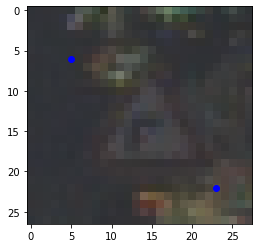

In [5]:
#ORIGINALE
im = io.imread('Train/20/00020_00000_00001.png')
plt.plot(5,6, 'bo')
plt.plot(23,22, 'bo')
plt.imshow(im); plt.show()

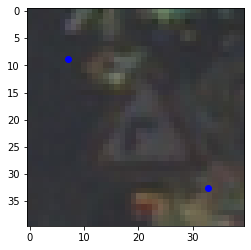

In [25]:
#RESIZED
im = io.imread('Train_resized/20/00020_00000_00001.jpeg')
plt.plot(7.142857,8.888889, 'bo')
plt.plot(32.857143,32.592593, 'bo')
plt.imshow(im); plt.show()

In [37]:
transforms = Sequence([RandomShear(0.25)]) #RandomRotate(20), RandomScale(0.2, diff = True), RandomShear(0.25)

In [38]:
img, bboxes = transforms(im, np.array([[7.1, 8.8, 32.8, 32.6, 0]])) #alla fine non so perchè mette lo zero ( o l'uno)

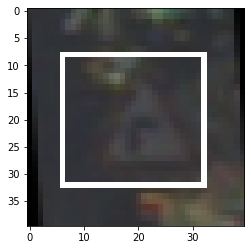

In [39]:
plt.imshow(draw_rect(img, bboxes))

## Creo le immagini con data agumentation

In [14]:
diz = {}
conta = 0
directory = r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\Train_resized'     
out_directory = r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\Train_resized_aug'  
for file_number in os.listdir(directory):
    print('folder number: '+ str(file_number))
    for img in os.listdir(directory+'\\' + file_number):
        d = {}
        im = Image.open(directory+ '\\' + file_number + '\\' + img)
        im_name = 'Train' + '/' + file_number + '/' + img
        arr_imm = np.array(im)
        rx1 = float(df_tr[df_tr['Path'] == im_name.replace('jpeg', 'png')]['x1'])
        rx2 = float(df_tr[df_tr['Path'] == im_name.replace('jpeg', 'png')]['x2'])
        ry1 = float(df_tr[df_tr['Path'] == im_name.replace('jpeg', 'png')]['y1'])
        ry2 = float(df_tr[df_tr['Path'] == im_name.replace('jpeg', 'png')]['y2'])
        clss = int(df_tr[df_tr['Path'] == im_name.replace('jpeg', 'png')]['ClassId'])
        d['rx1'] = rx1
        d['rx2'] = rx2
        d['ry1'] = ry1
        d['ry2'] = ry2
        d['class'] = clss
        diz['Train_resized_aug' + '/' + file_number + '/' + img] = d
        img_aug, bboxes = transforms(arr_imm, np.array([[rx1, ry1, rx2, ry2, 0]]))
        Image.fromarray(img_aug).save(out_directory + '\\' + file_number + '\\' + img.replace(".jpeg", "") + '_aug' + '.jpeg', 'JPEG', quality=100)
        d = {}
        d['rx1'] = bboxes[0][0]
        d['ry1'] = bboxes[0][1]
        d['rx2'] = bboxes[0][2]
        d['ry2'] = bboxes[0][3]    
        d['class'] = clss
        im_name2 = 'Train_resized_aug' + '/' + file_number + '/' + img.replace(".jpeg", "") + '_aug' + '.jpeg'
        #print(im_name2)
        diz[im_name2] = d
    conta = conta + 1
    #if conta > 1:
        #break

folder number: 0
folder number: 1
folder number: 10
folder number: 11
folder number: 12
folder number: 13
folder number: 14
folder number: 15
folder number: 16
folder number: 17
folder number: 18
folder number: 19
folder number: 2
folder number: 20
folder number: 21
folder number: 22
folder number: 23
folder number: 24
folder number: 25
folder number: 26
folder number: 27
folder number: 28
folder number: 29
folder number: 3
folder number: 30
folder number: 31
folder number: 32
folder number: 33
folder number: 34
folder number: 35
folder number: 36
folder number: 37
folder number: 38
folder number: 39
folder number: 4
folder number: 40
folder number: 41
folder number: 42
folder number: 5
folder number: 6
folder number: 7
folder number: 8
folder number: 9


In [15]:
#df_aug = pd.DataFrame.from_dict(diz, orient='index')

In [23]:
#df_aug['Path']=df_aug.index

In [24]:
#df_aug.to_csv('Train_aug.csv', index = False)

## Importo le immagini e creo i vettori di train e test

In [30]:
data=[]
labels=[]
y_plus = np.array([[0.,0.,0.,0.]], float) # eliminerò questa riga, mi serve per la dimensione

height = 40
width = 40
channels = 3
classes = 43
n_inputs = height * width * channels
for i in range(0,classes):
    print(classes)
    path = "Train_resized_aug/{0}/".format(i)
    Class=os.listdir(path)
    for a in Class:
        rx1 = df_tr_aug[df_tr_aug['Path']==path+a]['rx1']
        rx2 = df_tr_aug[df_tr_aug['Path']==path+a]['rx2']
        ry1 = df_tr_aug[df_tr_aug['Path']==path+a]['ry1']
        ry2 = df_tr_aug[df_tr_aug['Path']==path+a]['ry2']
        clss = df_tr_aug[df_tr_aug['Path']==path+a]['class']
        image=io.imread(path+a)
        #image_from_array = Image.fromarray(image)
        #size_image = image_from_array.resize((height, width))
        data.append(image)
        labels.append(int(clss))
        y_i = np.array([float(rx1), float(ry1), float(rx2), float(ry2)]).transpose()
        y_plus = np.vstack((y_plus, y_i))

43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43


In [31]:
X = np.array(data)

In [32]:
Y = np.array(labels)

In [33]:
Y_cat = ks.utils.to_categorical(Y)

In [34]:
y_plus = y_plus[1:,:]

In [35]:
Y = np.concatenate([Y_cat, y_plus], axis = 1)

In [36]:
Y = np.concatenate([np.expand_dims(np.ones(78418), axis = 1), Y], axis = 1)

L'array y_train ha i seguenti valori:
- è un segnale? si = 1, no = 0 (binaria)
- 0...43 classi
- rx1
- rx2
- ry1
- ry2

In [37]:
np.save('X', X)
np.save('Y', Y)

In [20]:
data_test=[]
labels_test=[]
path = "Test_resized/"
Class=os.listdir(path)
y_plus = np.array([[0.,0.,0.,0.]], float) # eliminerò questa riga, mi serve per la dimensione

for i in Class:
    image=io.imread(path+i)
    #image_from_array = Image.fromarray(image)
    data_test.append(image)
    im_name = 'Test/' + i
    im_name = im_name.replace("jpeg", "png")
    rx1 = float(df_tst[df_tst['Path']==im_name]['Roi.X1'])
    rx2 = float(df_tst[df_tst['Path']==im_name]['Roi.X2'])
    ry1 = float(df_tst[df_tst['Path']==im_name]['Roi.Y1'])
    ry2 = float(df_tst[df_tst['Path']==im_name]['Roi.Y2'])
    clss = int(df_tst[df_tst['Path']== im_name]['ClassId'])
    labels_test.append(int(clss))
    y_i = np.array([float(rx1), float(ry1), float(rx2), float(ry2)]).transpose()
    y_plus = np.vstack((y_plus, y_i))

In [21]:
X_test = np.array(data_test)

In [22]:
Y_test = np.array(labels_test)

In [23]:
Y_test_cat = ks.utils.to_categorical(Y_test)
y_plus = y_plus[1:,:]
y_test = np.concatenate([Y_test_cat, y_plus], axis = 1)
y_test = np.concatenate([np.expand_dims(np.ones(12630), axis = 1), y_test], axis = 1)

In [24]:
np.save('X_test', X_test)
np.save('y_test', y_test)

Importo le immagini che non corrispondono a segnali

In [41]:
data_ns=[]
path = "Google_CRCV_dataset_40_40/"
Class=os.listdir(path)
for i in Class:
    image=io.imread(path+i)
    data_ns.append(image)

In [42]:
not_signals = np.array(data_ns)

In [62]:
data_ns=[]
path = "Google_CRCV_dataset_40_40_test/"
Class=os.listdir(path)
for i in Class:
    image=io.imread(path+i)
    data_ns.append(image)

In [63]:
not_signals_test = np.array(data_ns)

## Creo gli esempi (di non segnali) prendendo dei crop dai segnali

In [ ]:
Image.open("test.jpg")

In [8]:
image=Image.open(r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\Train_resized\0\00000_00000_00000.jpeg')

In [119]:
def random_crop(image):
    left_min = 0 
    left_max = np.array(image).shape[0]-13
    top_min = 0
    top_max = np.array(image).shape[1]-13
    left = random.randint(left_min, left_max)
    top = random.randint(top_min, top_max)
    right = left + 12
    bottom = top + 12
    im1 = image.crop((left, top, right, bottom))
    return im1

In [120]:
cropped_im = random_crop(image)

In [121]:
resize_methods = [Image.BICUBIC, Image.NEAREST]

In [122]:
im_res= cropped_im.resize((40, 40), random.choice(resize_methods))

In [127]:
resize_methods = [Image.BICUBIC, Image.NEAREST]
directory = r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\Train_resized'     
out_directory = r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\crop_segnali'  
for file_number in os.listdir(directory):
    print('folder number: '+ str(file_number))
    for img in os.listdir(directory+'\\' + file_number):
        im = Image.open(directory+ '\\' + file_number + '\\' + img)
        cropped_im = random_crop(im)
        im_res= cropped_im.resize((40, 40), random.choice(resize_methods))
        im_name = file_number + '/' + img
        im_res.save(out_directory + '\\' + img, 'JPEG', quality=100)

folder number: 0
folder number: 1
folder number: 10
folder number: 11
folder number: 12
folder number: 13
folder number: 14
folder number: 15
folder number: 16
folder number: 17
folder number: 18
folder number: 19
folder number: 2
folder number: 20
folder number: 21
folder number: 22
folder number: 23
folder number: 24
folder number: 25
folder number: 26
folder number: 27
folder number: 28
folder number: 29
folder number: 3
folder number: 30
folder number: 31
folder number: 32
folder number: 33
folder number: 34
folder number: 35
folder number: 36
folder number: 37
folder number: 38
folder number: 39
folder number: 4
folder number: 40
folder number: 41
folder number: 42
folder number: 5
folder number: 6
folder number: 7
folder number: 8
folder number: 9


In [135]:
conta = 0
resize_methods = [Image.BICUBIC, Image.NEAREST]
br = False
directory = r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\Train_resized'     
out_directory = r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\crop_segnali_test'  
for file_number in os.listdir(directory):
    print('folder number: '+ str(file_number))
    for img in os.listdir(directory+'\\' + file_number):
        im = Image.open(directory+ '\\' + file_number + '\\' + img)
        cropped_im = random_crop(im)
        im_res= cropped_im.resize((40, 40), random.choice(resize_methods))
        im_name = file_number + '/' + img
        im_res.save(out_directory + '\\' + img, 'JPEG', quality=100)
        conta = conta + 1
        if (conta == 11000):
            br = True
    if (br == True):
        break
            

folder number: 0
folder number: 1
folder number: 10
folder number: 11
folder number: 12
folder number: 13
folder number: 14
folder number: 15


In [136]:
data_crop=[]
path = out_directory
Class=os.listdir(path)
for i in Class:
    image=io.imread(path+ '\\'+i)
    data_crop.append(image)

In [137]:
crop_segnali_test = np.array(data_crop)

In [2]:
out_directory = r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\alberi_landscapes_40_40_test'  

In [3]:
data_alb_len=[]
path = out_directory
Class=os.listdir(path)
b = False
for i in Class:
    if (b == True):
        print(i)
    if (i == 'im96420.jpg'):
        b = True
    image=io.imread(path+ '\\'+i)
    if (len(image.shape) == 3):
        data_alb_len.append(image)

im965.jpg
im966.jpg
im967.jpg
im968.jpg
im969.jpg
im97.jpg
im970.jpg
im971.jpg
im972.jpg
im973.jpg
im974.jpg
im975.jpg
im976.jpg
im977.jpg
im978.jpg
im979.jpg
im98.jpg
im980.jpg
im981.jpg
im982.jpg
im983.jpg
im984.jpg
im985.jpg
im986.jpg
im987.jpg
im988.jpg
im989.jpg
im99.jpg
im990.jpg
im991.jpg
im992.jpg
im993.jpg
im994.jpg
im995.jpg
im996.jpg
im997.jpg
im998.jpg
im999.jpg


In [4]:
alberi_lendscapes_test = np.array(data_alb_len)

### CREO IL TEST PER LA PRIMA RETE

In [24]:
directory = r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\test_set_non_segn_speriamo_bene'   
X_0 = np.zeros([1,40,40,3])
conta = 0
for img in os.listdir(directory):
    try:
        im = Image.open(directory + '\\' + img)
        im = np.array(im)
        #print(im.shape)
        X_0 = np.concatenate([X_0, np.expand_dims(im, axis = 0)], axis = 0)
    except ValueError:
        pass
    conta += 1
    if (conta%500==0):
        print(conta)
X_0 = X_0[1:, :, :,:]

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000


In [26]:
y_0 = np.zeros(X_0.shape[0])

In [31]:
X_test1 = np.load('X_test.npy')
y_test1 = np.ones(X_test1.shape[0])

In [32]:
X_test = np.concatenate([X_0, X_test1], axis = 0)

In [33]:
y_test = np.concatenate([y_0, y_test1], axis = 0)

## Salvo gli array

In [34]:
np.save('array_da_importare\X_test_speriamo_bene', X_test)
np.save('array_da_importare\y_test_speriamo_bene', y_test)

In [5]:
np.save('alberi_lends_test', alberi_lendscapes_test)

In [47]:
np.save('alberi_lends', alberi_lendscapes)
np.save('crop_segnali', crop_segnali)
np.save('crop_segnali_test', crop_segnali_test)
np.save('not_signals_array', not_signals)
np.save('X', X)
np.save('Y', Y)
np.save('X_test', X_test)
np.save('y_test', y_test)

In [64]:
np.save('not_signals_test', not_signals_test)